In [ ]:
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import add_path
import toolkit.allen_helpers.stimuli as st
from toolkit.pipeline.data_io import SessionDirectory
from toolkit.analysis.signal import bandpass_filter, bandpass_power
from toolkit.pipeline.signal import bandpass_filter_blocks
from toolkit.plots.plots import plot_channel_signal_array


pd.set_option('display.max_columns', None)

with open('config.json') as f:
    config = json.load(f)

## Get session and load data

In [ ]:
session_id = config['session_id']
ecephys_structure_acronym = config['ecephys_structure_acronym']
print(f"Session ID: {session_id}")

In [ ]:
session_dir = SessionDirectory(session_id, ecephys_structure_acronym, cache_lfp=True)

lfp_channels = session_dir.load_lfp_channels()
probe_info = session_dir.load_probe_info()
if not session_dir.has_lfp_data:
    raise ValueError(f"Session {session_id} has no LFP data")

session = session_dir.session

c:\Users\ziaochen\.conda\envs\neuro2\lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [ ]:
central_channels = probe_info['central_channels']

channel_positions = lfp_channels['probe_vertical_position']

lfp_array = session_dir.load_lfp(channel=lfp_channels.index)
csd_array = session_dir.load_csd()

c:\Users\ziaochen\.conda\envs\neuro2\lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
c:\Users\ziaochen\.conda\envs\neuro2\lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
c:\Users\ziaochen\.conda\envs\neuro2\lib\site-pa

## Analyze data

In [4]:
stimulus_presentations = session.stimulus_presentations
session.stimulus_names

c:\Users\ziaochen\.conda\envs\neuro2\lib\site-packages\hdmf\spec\namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings_contrast',
 'natural_movie_one_more_repeats',
 'natural_movie_one_shuffled',
 'drifting_gratings_75_repeats',
 'dot_motion']

In [ ]:
_, baseline_window = st.initial_spontaneous_presentation(stimulus_presentations)

In [ ]:
flashes_trials = st.get_stimulus_trials(stimulus_presentations, 'flashes')
flashes_blocks = st.get_stimulus_blocks(flashes_trials)

In [13]:
freq_band = (50., 60.)
extend_time = 1.0
flashes_window = (-0.2, flashes_trials.duration + 0.75)  # < extend_time

In [14]:
csd_filtered = bandpass_filter_blocks(
    csd_array, flashes_blocks, freq_band,
    extend_time=extend_time,
    include_filtered=False,
    include_amplitude=True
)

csd_power = bandpass_power(csd_filtered)

csd_baseline_power = bandpass_power(bandpass_filter(
    csd_array.sel(time=slice(*baseline_window)),
    freq_band,
    include_filtered=False,
    include_amplitude=True
)).mean(dim='time', keep_attrs=True)

In [15]:
lfp_filtered = bandpass_filter_blocks(
    lfp_array, flashes_blocks, freq_band,
    extend_time=extend_time,
    include_filtered=False,
    include_amplitude=True
)

lfp_power = bandpass_power(lfp_filtered)

lfp_baseline_power = bandpass_power(bandpass_filter(
    lfp_array.sel(time=slice(*baseline_window)),
    freq_band,
    include_filtered=False,
    include_amplitude=True
)).mean(dim='time', keep_attrs=True)

In [ ]:
aligned_csd = st.align_trials_from_blocks(
    csd_array, flashes_blocks, window=flashes_window
).mean(dim='presentation_id', keep_attrs=True)

aligned_csd_power = st.align_trials_from_blocks(
    csd_power, flashes_blocks, window=flashes_window
).mean(dim='presentation_id', keep_attrs=True)

In [ ]:
aligned_lfp = st.align_trials_from_blocks(
    lfp_array, flashes_blocks, window=flashes_window
).mean(dim='presentation_id', keep_attrs=True)

aligned_lfp_power = st.align_trials_from_blocks(
    lfp_power, flashes_blocks, window=flashes_window
).mean(dim='presentation_id', keep_attrs=True)

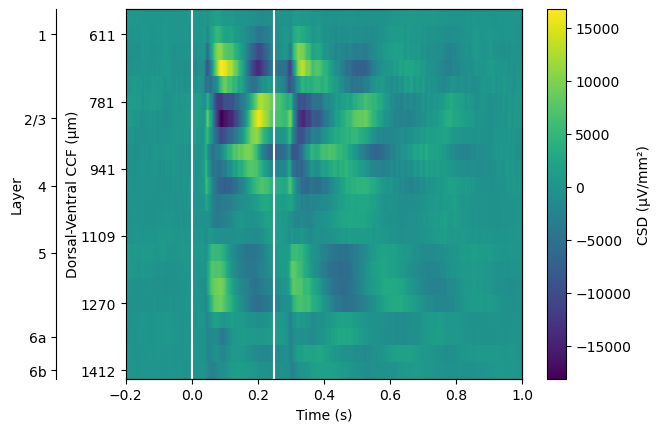

In [18]:
ax = plot_channel_signal_array(
    aligned_csd.time_from_presentation_onset,
    channel_positions,
    aligned_csd,
    central_channels=central_channels,
    ccf_coordinates=lfp_channels['dorsal_ventral_ccf_coordinate'],
    clabel='CSD'
)

ax.axvline(0, color='w')
ax.axvline(flashes_trials.duration, color='w')

plt.show()

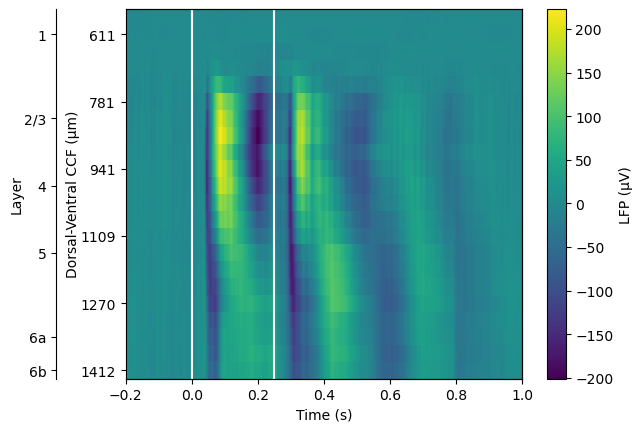

In [19]:
ax = plot_channel_signal_array(
    aligned_lfp.time_from_presentation_onset,
    channel_positions,
    aligned_lfp,
    central_channels,
    lfp_channels['dorsal_ventral_ccf_coordinate'],
    clabel='LFP'
)

ax.axvline(0, color='w')
ax.axvline(flashes_trials.duration, color='w')

plt.show()

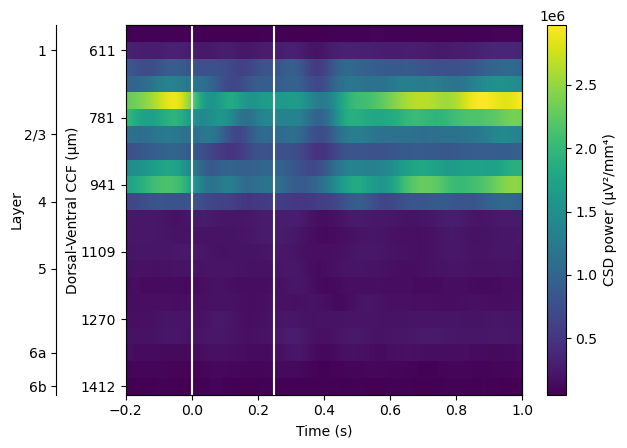

In [20]:
ax = plot_channel_signal_array(
    aligned_csd_power.time_from_presentation_onset,
    channel_positions,
    aligned_csd_power,
    central_channels,
    lfp_channels['dorsal_ventral_ccf_coordinate'],
    clabel='CSD power'
)

ax.axvline(0, color='w')
ax.axvline(flashes_trials.duration, color='w')

plt.show()

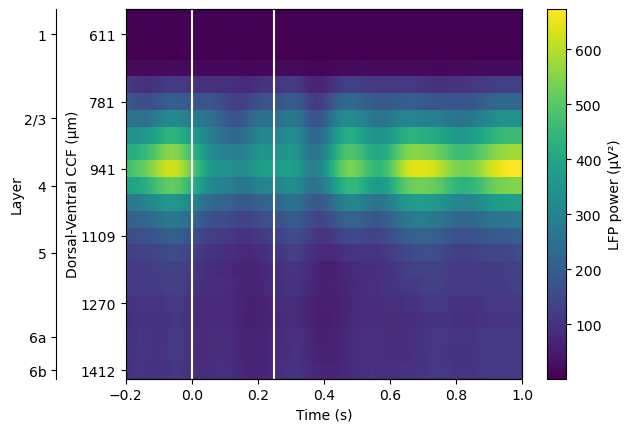

In [21]:
ax = plot_channel_signal_array(
    aligned_lfp_power.time_from_presentation_onset,
    channel_positions,
    aligned_lfp_power,
    central_channels,
    lfp_channels['dorsal_ventral_ccf_coordinate'],
    clabel='LFP power'
)

ax.axvline(0, color='w')
ax.axvline(flashes_trials.duration, color='w')

plt.show()

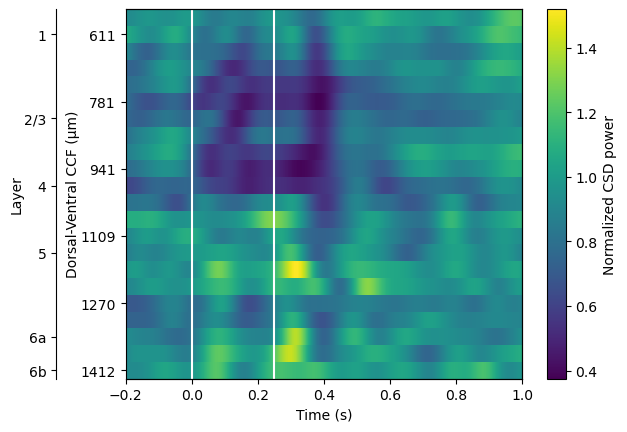

In [22]:
ax = plot_channel_signal_array(
    aligned_csd_power.time_from_presentation_onset,
    channel_positions,
    aligned_csd_power / csd_baseline_power,
    central_channels,
    lfp_channels['dorsal_ventral_ccf_coordinate'],
    clabel='Normalized CSD power'
)

ax.axvline(0, color='w')
ax.axvline(flashes_trials.duration, color='w')

plt.show()

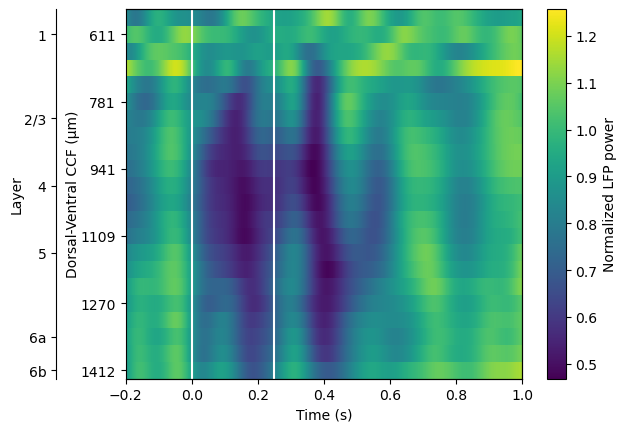

In [23]:
ax = plot_channel_signal_array(
    aligned_lfp_power.time_from_presentation_onset,
    channel_positions,
    aligned_lfp_power / lfp_baseline_power,
    central_channels,
    lfp_channels['dorsal_ventral_ccf_coordinate'],
    clabel='Normalized LFP power'
)

ax.axvline(0, color='w')
ax.axvline(flashes_trials.duration, color='w')

plt.show()